### 📌 **Note**
* **This notebook is written in a raw style (no reusable functions/classes).**  
* **The purpose is to clearly demonstrate my end-to-end workflow on this dataset, rather than abstracting steps into functions.**
* **In a production or reusable codebase, I would modularize the code for better maintainability and scalability.**

---------------------------------------------------------------------

## **Banks lose billions in loan defaults every year. Predicting whether a loan applicant will default helps reduce risk**

# **🔥Let's Predict The Status of Loan Default**

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


**Data Cleaning And Preprocessing**

In [ ]:
df = pd.read_csv('/content/Loan_Default_dataset.csv')

In [ ]:
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758.0,CIB,25-34,to_inst,98.728814,south,direct,1.0,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552.0,EXP,55-64,to_inst,NaN,North,direct,1.0,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834.0,CIB,35-44,to_inst,80.019685,south,direct,0.0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587.0,CIB,45-54,not_inst,69.376900,North,direct,0.0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602.0,EXP,25-34,not_inst,91.886544,North,direct,0.0,39.0


In [ ]:
# Removing Unnecessary Features Like 'ID' and 'Year

df.drop(['ID', 'year'], axis =1, inplace=True)

In [ ]:
df['Gender'].mode()

,Gender
0,Joint


In [ ]:
# Replacing Unavailable Genders With 'Male', Because Male is the Most Occured Value

df['Gender'] = df['Gender'].map({
    'Male':'Male',
    'Female':'Female',
    'Sex Not Available':'Male'
})

In [ ]:
df['Gender'].value_counts()

,count
Gender,
Male,5808
Female,2077


In [ ]:
df.isna().sum()

,0
loan_limit,254
Gender,3091
approv_in_adv,68
loan_type,1
loan_purpose,8
Credit_Worthiness,1
open_credit,1
business_or_commercial,1
loan_amount,1
rate_of_interest,2685


In [ ]:
# Filling Missing Values Of Object Data-Type with 'Mode' and 'Int' with 'Mean'

for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].fillna(df[col].mode()[0])
  else:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
# Using One-Hot Encoding To Convert Categorical Columns To 0 and 1

df_encoded = pd.get_dummies(df, drop_first = True).astype(int)

# Making Necessary Variables

X_initial = df_encoded.drop('Status', axis = 1) #This are just to find the best features
y_initial = df_encoded['Status'] #This are just to find the best features

X_initial.rename(columns = {
    'age_<25':'age_below_25',
    'age_>74':'age_above_74'
}, inplace = True)

In [ ]:
X_initial.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,...,age_45-54,age_55-64,age_65-74,age_below_25,age_above_74,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
0,116500,4,0,3263,360,118000,1740,758,98,45,...,0,0,0,0,0,1,0,0,1,1
1,206500,4,0,3263,360,500072,4980,552,72,37,...,0,1,0,0,0,1,0,0,0,1
2,406500,4,0,595,360,508000,9480,834,80,46,...,0,0,0,0,0,1,0,0,1,1
3,456500,4,0,3263,360,658000,11880,587,69,42,...,1,0,0,0,0,0,0,0,0,1
4,696500,4,0,0,360,758000,10440,602,91,39,...,0,0,0,0,0,0,0,0,0,1


**Exploratory Data Analysis (EDA)**

In [ ]:
# Using XGBoost To Find Best Features

from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_initial, y_initial)

feature_importance = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_initial.columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

<Axes: xlabel='Importance', ylabel='Feature'>

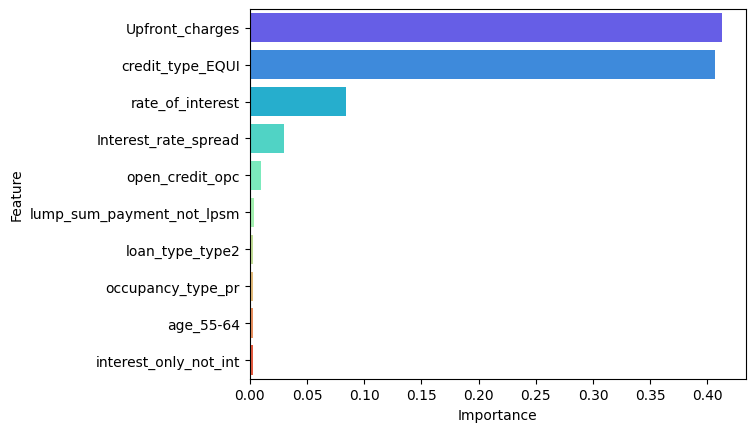

In [ ]:
# Visual Representation of Feature Importance Using Seaborn

sns.barplot(x = 'Importance', y = 'Feature', data = feature_importance_df.head(10), palette = 'rainbow')

In [ ]:
# Only Top 7 Features Have Some Sort Of Corelation With 'Status'

final_df = feature_importance_df.head(7)['Feature'].tolist()
model_df = df_encoded[final_df + ['Status']]

In [ ]:
# Reassigning Values Of 'X', 'y' and 'X_scaled'

X = model_df.drop('Status', axis = 1)
y = model_df['Status']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Model Training (Logistic Regression)**

In [72]:
# Performing Cross Validation On Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_cv = LogisticRegression(
    max_iter = 1000,
    class_weight = 'balanced',
    random_state = 42
)

lr_cv_scores = cross_val_score(lr_cv, X_scaled, y, cv = 5, scoring = 'recall')

In [73]:
lr_cv_scores

array([0.99814815, 0.99814815, 1.        , 1.        , 0.99628942])

In [ ]:
# Splitting Data Into Training and Testing Parts and Making Logistic Regression Model

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

lr = LogisticRegression(
    max_iter = 1000,
    class_weight = 'balanced',
    random_state = 42
)
lr.fit(X_train, y_train)

lr_predict_train = lr.predict(X_train)
lr_predict_test = lr.predict(X_test)

lr_scores = pd.DataFrame({
    'LR Train': [roc_auc_score(y_train, lr_predict_train), accuracy_score(y_train, lr_predict_train), f1_score(y_train, lr_predict_train), recall_score(y_train, lr_predict_train)],
    'LR Test': [roc_auc_score(y_test, lr_predict_test), accuracy_score(y_test, lr_predict_test), f1_score(y_test, lr_predict_test), recall_score(y_test, lr_predict_test)]
}, index = ['ROC_AUC', 'Accuracy', 'F1 Score', 'Recall'])


In [74]:
lr_scores

,LR Train,LR Test
ROC_AUC,0.880812,0.878403
Accuracy,0.820159,0.816940
F1 Score,0.731964,0.729839
Recall,1.000000,1.000000


**Let's Now Try HyperParameter Tuning On Logistc Regression**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = RandomizedSearchCV(lr, {
    'max_iter' : [500, 1000, 1500, 2000, 2500, 3000],
    'class_weight' : ['balanced', 'balanced_subsample'],
    'penalty' : ['l1', 'l2', 'elasticnet', None]
}, n_iter=15, cv = 5, random_state=42)

param_grid.fit(X_train, y_train)

best_parameters = param_grid.best_params_

In [ ]:
best_parameters

{'penalty': None, 'max_iter': 2500, 'class_weight': 'balanced'}

In [ ]:
# Let's Use Best Parameters Now

lr_new = LogisticRegression(
    max_iter = best_parameters['max_iter'],
    class_weight = best_parameters['class_weight'],
    penalty = best_parameters['penalty'],
    random_state = 42
)

lr_new.fit(X_train, y_train)
lr_new_predict_train = lr_new.predict(X_train)
lr_new_predict_test = lr_new.predict(X_test)

lr_new_scores = pd.DataFrame({
    'LR_Hyper Train': [roc_auc_score(y_train, lr_new_predict_train), accuracy_score(y_train, lr_new_predict_train), f1_score(y_train, lr_new_predict_train), recall_score(y_train, lr_new_predict_train)],
    'LR_Hyper Test': [roc_auc_score(y_test, lr_new_predict_test), accuracy_score(y_test, lr_new_predict_test), f1_score(y_test, lr_new_predict_test), recall_score(y_test, lr_new_predict_test)]
}, index = ['ROC_AUC', 'Accuracy', 'F1 Score', 'Recall'])


In [ ]:
lr_new_scores

,LR_Hyper Train,LR_Hyper Test
ROC_AUC,0.880963,0.879613
Accuracy,0.820387,0.818761
F1 Score,0.732213,0.731806
Recall,1.000000,1.000000


# **Model Training (KNN)**

In [ ]:
# Performing Cross Validation On KNN

from sklearn.neighbors import KNeighborsClassifier

knn_cv = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'auto',
)

knn_cv_scores = cross_val_score(knn_cv, X_scaled, y, cv = 5, scoring = 'recall')

In [ ]:
knn_cv_scores

array([1.        , 1.        , 1.        , 1.        , 0.99628942])

In [ ]:
# Splitting Data Into Training and Testing Parts and Making KNN Model

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

knn = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'auto',
)

knn.fit(X_train, y_train)
knn_predict_train = knn.predict(X_train)
knn_predict_test = knn.predict(X_test)

knn_scores = pd.DataFrame({
    'KNN Train': [roc_auc_score(y_train, knn_predict_train), accuracy_score(y_train, knn_predict_train), f1_score(y_train, knn_predict_train), recall_score(y_train, knn_predict_train)],
    'KNN Test': [roc_auc_score(y_test, knn_predict_test), accuracy_score(y_test, knn_predict_test), f1_score(y_test, knn_predict_test), recall_score(y_test, knn_predict_test)]
}, index = ['ROC_AUC', 'Accuracy', 'F1 Score', 'Recall'])


In [ ]:
knn_scores

,KNN Train,KNN Test
ROC_AUC,0.996679,0.994858
Accuracy,0.994989,0.992259
F1 Score,0.989899,0.984587
Recall,1.000000,1.000000


**The Main Thing To Be Noticed Here is That KNN Has Given Way More Accuracy and F1-Score Than Logistic Regression. The Reason is Very Simple, When We Did Feature Engineering We Only Got 7 Features That Were Actually Having An Impact On Our Targeted Feature, By Doing This The Number Of Dimensions For KNN Reduced Significantly, and KNN Works Best With Low Dimensions.**

# **Model Training (SVM)**

In [ ]:
# Performing Cross Validation On SVM

from sklearn.svm import SVC

svm_cv = SVC(
    C = 1.0,
    kernel = 'rbf',
    gamma = 'scale',
    class_weight = 'balanced',
    random_state = 42
)

svm_cv_scores = cross_val_score(svm_cv, X_scaled, y, cv = 5, scoring = 'recall')

In [ ]:
svm_cv_scores

array([1., 1., 1., 1., 1.])

In [ ]:
# Splitting Data Into Training and Testing Parts and Making SVM Model

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

svm = SVC(
    C = 1.0,
    kernel = 'rbf',
    gamma = 'scale',
    class_weight = 'balanced',
    random_state = 42
)

svm.fit(X_train, y_train)
svm_pred_train = svm.predict(X_train)
svm_pred_test = svm.predict(X_test)

svm_scores = pd.DataFrame({
    'SVM Train': [roc_auc_score(y_train, svm_pred_train), accuracy_score(y_train, svm_pred_train), f1_score(y_train, svm_pred_train), recall_score(y_train, svm_pred_train)],
    'SVM Test': [roc_auc_score(y_test, svm_pred_test), accuracy_score(y_test, svm_pred_test), f1_score(y_test, svm_pred_test), recall_score(y_test, svm_pred_test)]
}, index = ['ROC_AUC', 'Accuracy', 'F1 Score', 'Recall'])


In [ ]:
svm_scores

,SVM Train,SVM Test
ROC_AUC,0.947011,0.950696
Accuracy,0.920046,0.925774
F1 Score,0.859992,0.869496
Recall,1.000000,1.000000


**SVM Scores are Good, But Not as Good as of KNN, Let's Try Hyper-Parameter Tuning On SVM**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

svm_grid = RandomizedSearchCV(svm, {
    'C' : [0.1, 1, 1.5, 10],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma' : ['scale', 'auto'],
    'class_weight' : ['balanced', 'balanced_subsample']
}, n_iter=15, cv = 5, random_state=42)

svm_grid.fit(X_train, y_train)



RandomizedSearchCV(cv=5,
                   estimator=SVC(class_weight='balanced', random_state=42),
                   n_iter=15,
                   param_distributions={'C': [0.1, 1, 1.5, 10],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42)

In [ ]:
svm_best_parameters = svm_grid.best_params_
svm_best_parameters

{'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 1.5}

In [ ]:
# Let's Use Best Parameters Now

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

svm_new = SVC(
    C = svm_best_parameters['C'],
    kernel = svm_best_parameters['kernel'],
    gamma = svm_best_parameters['gamma'],
    class_weight = svm_best_parameters['class_weight']
)

svm_new.fit(X_train, y_train)
svm_new_pred_train = svm_new.predict(X_train)
svm_new_pred_test = svm_new.predict(X_test)

svm_new_scores = pd.DataFrame({
    'SVM_Hyper Train': [roc_auc_score(y_train, svm_new_pred_train), accuracy_score(y_train, svm_new_pred_train), f1_score(y_train, svm_new_pred_train), recall_score(y_train, svm_new_pred_train)],
    'SVM_Hyper Test': [roc_auc_score(y_test, svm_new_pred_test), accuracy_score(y_test, svm_new_pred_test), f1_score(y_test, svm_new_pred_test), recall_score(y_test, svm_new_pred_test)]
}, index = ['Accuracy', 'F1 Score', 'Recall', 'ROC_AUC'])


In [ ]:
svm_new_scores

,SVM_Hyper Train,SVM_Hyper Test
Accuracy,0.949955,0.954930
F1 Score,0.924487,0.932149
Recall,0.866734,0.879352
ROC_AUC,1.000000,1.000000


**Very Little Improvement Compared To The Previous SVM Model Before Hyper-Parameter Tuning, Now Let's Try Stacking on This Data, Since KNN Has Very Good Results We'll Use KNN as Our Meta Learner**

In [ ]:
base_learners = [
    ('lr', lr),
    ('svm', svm_new)
]

meta_learner = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'auto',
)

from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators = base_learners,
    final_estimator = meta_learner,
    cv = 5
)

stacking_model.fit(X_train, y_train)

stacking_predict_train = stacking_model.predict(X_train)
stacking_predict_test = stacking_model.predict(X_test)

In [ ]:
stacking_scores = pd.DataFrame({
    'Stacking Train': [roc_auc_score(y_train, stacking_predict_train), accuracy_score(y_train, stacking_predict_train), f1_score(y_train, stacking_predict_train), recall_score(y_train, stacking_predict_train)],
    'Stacking Test': [roc_auc_score(y_test, stacking_predict_test), accuracy_score(y_test, stacking_predict_test), f1_score(y_test, stacking_predict_test), recall_score(y_test, stacking_predict_test)]
}, index = ['Accuracy', 'F1 Score', 'Recall', 'ROC_AUC'])

stacking_scores

,Stacking Train,Stacking Test
Accuracy,0.995072,0.994858
F1 Score,0.993508,0.992259
Recall,0.986930,0.984587
ROC_AUC,0.998145,1.000000


**Let's Compare Results**

In [ ]:
scores = pd.DataFrame({
    'Model': ['LR', 'LR Hyper', 'KNN', 'SVM', 'SVM Hyper', 'Stacking'],
    'Train ROC_AUC' : [lr_scores['LR Train']['ROC_AUC'], lr_new_scores['LR_Hyper Train']['ROC_AUC'], knn_scores['KNN Train']['ROC_AUC'], svm_scores['SVM Train']['ROC_AUC'], svm_new_scores['SVM_Hyper Train']['ROC_AUC'], stacking_scores['Stacking Train']['ROC_AUC']],
    'Test ROC_AUC' : [lr_scores['LR Test']['ROC_AUC'], lr_new_scores['LR_Hyper Test']['ROC_AUC'], knn_scores['KNN Test']['ROC_AUC'], svm_scores['SVM Test']['ROC_AUC'], svm_new_scores['SVM_Hyper Test']['ROC_AUC'], stacking_scores['Stacking Test']['ROC_AUC']],
    'Train Accuracy': [lr_scores['LR Train']['Accuracy'], lr_new_scores['LR_Hyper Train']['Accuracy'], knn_scores['KNN Train']['Accuracy'], svm_scores['SVM Train']['Accuracy'], svm_new_scores['SVM_Hyper Train']['Accuracy'], stacking_scores['Stacking Train']['Accuracy']],
    'Test Accuracy': [lr_scores['LR Test']['Accuracy'], lr_new_scores['LR_Hyper Test']['Accuracy'], knn_scores['KNN Test']['Accuracy'], svm_scores['SVM Test']['Accuracy'], svm_new_scores['SVM_Hyper Test']['Accuracy'], stacking_scores['Stacking Test']['Accuracy']],
    'Train F1 Score': [lr_scores['LR Train']['F1 Score'], lr_new_scores['LR_Hyper Train']['F1 Score'], knn_scores['KNN Train']['F1 Score'], svm_scores['SVM Train']['F1 Score'], svm_new_scores['SVM_Hyper Train']['F1 Score'], stacking_scores['Stacking Train']['F1 Score']],
    'Test F1 Score': [lr_scores['LR Test']['F1 Score'], lr_new_scores['LR_Hyper Test']['F1 Score'], knn_scores['KNN Test']['F1 Score'], svm_scores['SVM Test']['F1 Score'], svm_new_scores['SVM_Hyper Test']['F1 Score'], stacking_scores['Stacking Test']['F1 Score']],
    'Train Recall': [lr_scores['LR Train']['Recall'], lr_new_scores['LR_Hyper Train']['Recall'], knn_scores['KNN Train']['Recall'], svm_scores['SVM Train']['Recall'], svm_new_scores['SVM_Hyper Train']['Recall'], stacking_scores['Stacking Train']['Recall']],
    'Test Recall' : [lr_scores['LR Test']['Recall'], lr_new_scores['LR_Hyper Test']['Recall'], knn_scores['KNN Test']['Recall'], svm_scores['SVM Test']['Recall'], svm_new_scores['SVM_Hyper Test']['Recall'], stacking_scores['Stacking Test']['Recall']]
})

scores = scores.sort_values(by = 'Test Recall', ascending = False)
scores

,Model,Train ROC_AUC,Test ROC_AUC,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train Recall,Test Recall
0,LR,0.880812,0.878403,0.820159,0.816940,0.731964,0.729839,1.000000,1.000000
1,LR Hyper,0.880963,0.879613,0.820387,0.818761,0.732213,0.731806,1.000000,1.000000
2,KNN,0.996679,0.994858,0.994989,0.992259,0.989899,0.984587,1.000000,1.000000
3,SVM,0.947011,0.950696,0.920046,0.925774,0.859992,0.869496,1.000000,1.000000
5,Stacking,0.998145,1.000000,0.995072,0.994858,0.993508,0.992259,0.986930,0.984587
4,SVM Hyper,1.000000,1.000000,0.949955,0.954930,0.924487,0.932149,0.866734,0.879352


# **Confusion Matrix Of Each Model**

<Axes: >

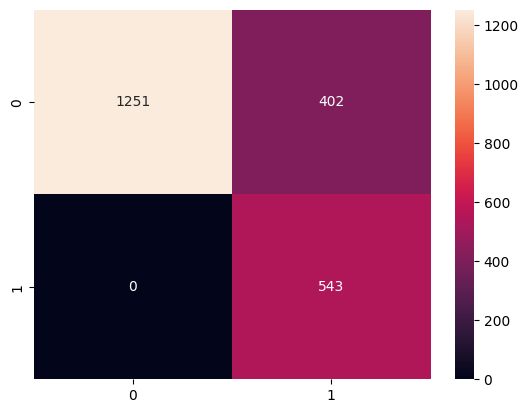

In [ ]:
# Logistic Regression

sns.heatmap(confusion_matrix(y_test, lr_predict_test), annot = True, fmt = 'd', cmap = 'rocket')

<Axes: >

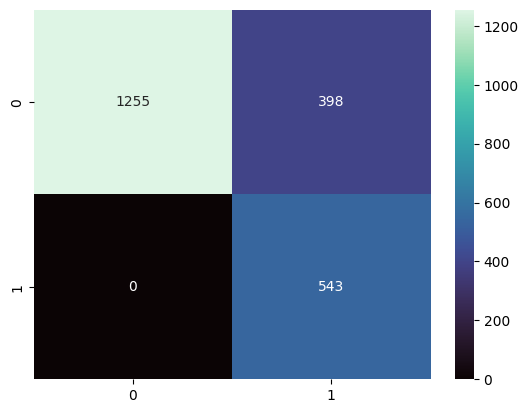

In [ ]:
# Logistic Regression (Hyper-Parameter Tuned)

sns.heatmap(confusion_matrix(y_test, lr_new_predict_test), annot = True, fmt = 'd', cmap = 'mako')

<Axes: >

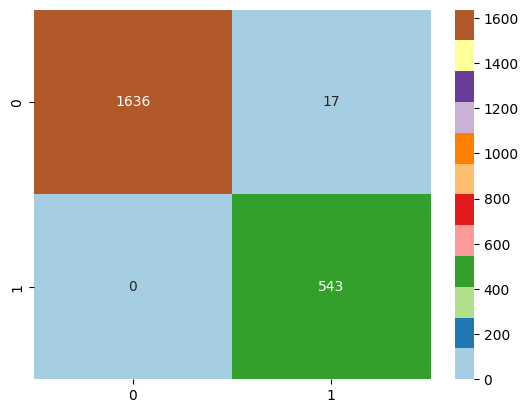

In [ ]:
# KNN

sns.heatmap(confusion_matrix(y_test, knn_predict_test), annot = True, fmt = 'd', cmap = 'Paired')

<Axes: >

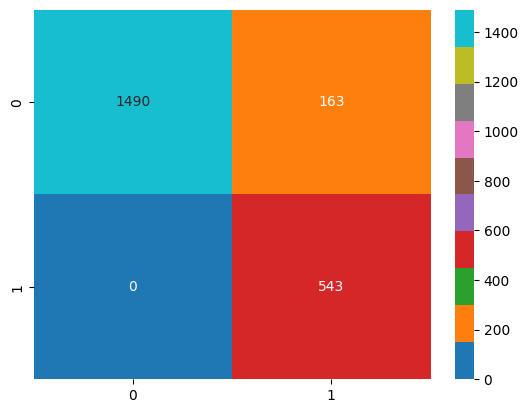

In [ ]:
# Support Vector Machine

sns.heatmap(confusion_matrix(y_test, svm_pred_test), annot = True, fmt = 'd', cmap = 'tab10')

<Axes: >

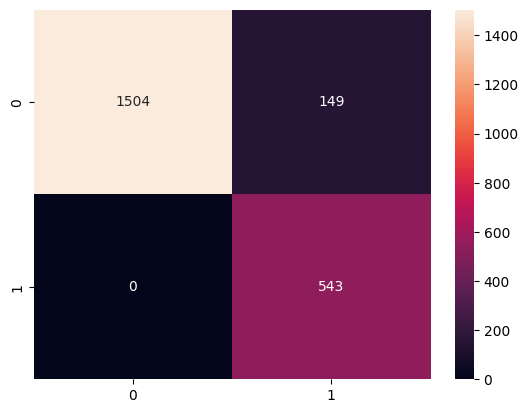

In [ ]:
# SVM (Hyper-Parameter Tuned)

sns.heatmap(confusion_matrix(y_test, svm_new_pred_test), annot = True, fmt = 'd', cmap = 'rocket')

<Axes: >

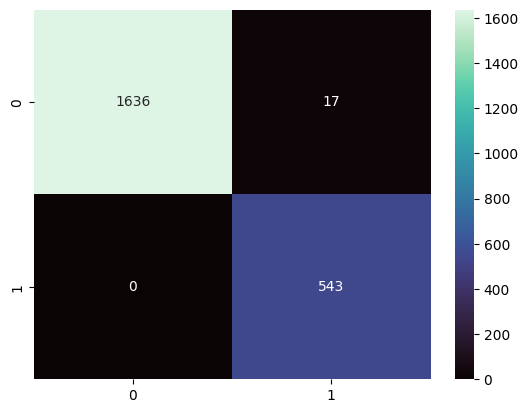

In [ ]:
# Stacking

sns.heatmap(confusion_matrix(y_test, stacking_predict_test), annot = True, fmt = 'd', cmap = 'mako')


In [ ]:
# Let's Find Highest Scores (Recall, F1_Score, Accuracy)

highest_train_accuracy = scores[scores['Train Accuracy'] == scores['Train Accuracy'].max()]['Model']
highest_test_accuracy = scores[scores['Test Accuracy'] == scores['Test Accuracy'].max()]['Model']

highest_train_f1 = scores[scores['Train F1 Score'] == scores['Train F1 Score'].max()]['Model']
highest_test_f1 = scores[scores['Test F1 Score'] == scores['Test F1 Score'].max()]['Model']

highest_train_recall = scores[scores['Train Recall'] == scores['Train Recall'].max()]['Model']
highest_test_recall = scores[scores['Test Recall'] == scores['Test Recall'].max()]['Model']

<Axes: xlabel='Model', ylabel='Test F1 Score'>

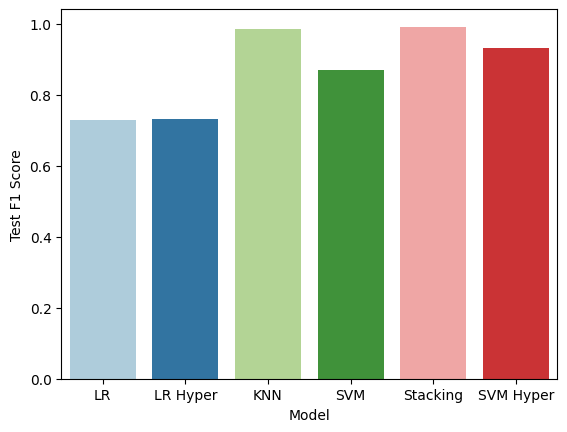

In [ ]:
# Visual Representation Of Models and Their F1 Scores

sns.barplot(x = 'Model', y = 'Test F1 Score', data = scores, palette = 'Paired')

<Axes: xlabel='Model', ylabel='Test Recall'>

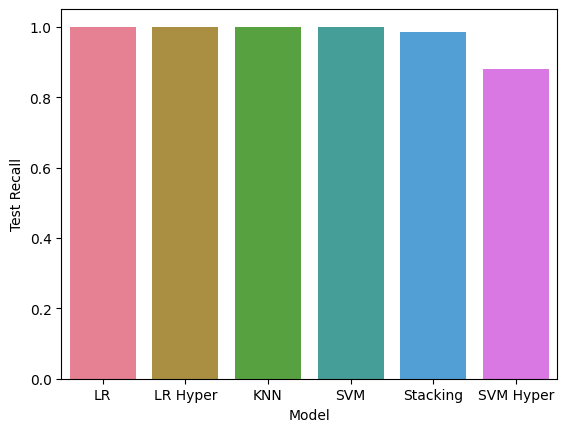

In [ ]:
# Visual Representation Of Models and Their Recall Scores

sns.barplot(x = 'Model', y = 'Test Recall', data = scores, palette = 'husl')

<Axes: xlabel='Model', ylabel='Test Accuracy'>

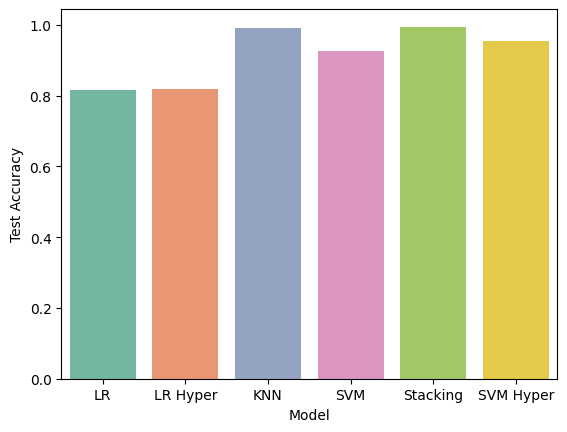

In [ ]:
# Visual Representation Of Models and Their Accuracy Scores

sns.barplot(x = 'Model', y = 'Test Accuracy', data = scores, palette = 'Set2')

# **Summary**

*   We Got A Dataset To Predict The Status Of Loan Default.
*   We Filled Null Values With Mean and Mode Depending On The Data-Type.
*   We Used One-Hot Encoding To Convert Categorical Features To 0 and 1.
*   We Used XGBoost To Find Most Corelated Features To Our Target Features.
*   We Found Only 7 Features That Were Actually Corelated To Our Target Feature.
*   We Made Models On That 7 Features.
*   We Made Logistic Regression, KNN and Support Vector Machine Models On The Data and Also Used Hyper-parameter Tuning On Logistic Regression and Support Vector Machine Models.
*   We Also Used Stacking To Improve The F1 Score and Accuracy.
*   Although, Even After Stacking KNN Has The Highest F1 Score of 0.978 and Recall Score Of 0.996
*   In This Particular Classification Dataset, KNN Was The Most Effective Model Because The Number Of Dimensions (Features) was Small and KNN Works Better on Dimensions are Less.
*   Recall Score Of Every Model Was Almost the Same Above 0.985
*   Since This Is Loan Default Prediction, Recall is Critical. Missing a Defaulter (False Negative) Is More Costly To Banks Than Wrongly Flagging a Safe Borrower (False Positive). That's Why We Prioritized Recall.
*   If We Talk About Confusion Matrix We Got Highest Performance From KNN and Stacking, KNN and Stacking Both Have Total 17 Type 1 Errors and 0 Type 2 Error.